# AS - TME9
2018--2019

---

Binome : Juliette Ortholand, Stieban Fernandez

In [85]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Préparation des données

In [4]:
## une fois le dataset telecharge, mettre download=False !
## Pour le test, train = False
## transform permet de faire un preprocessing des donnees (ici ?)
batch_size=600
nb_digits=10
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                                                          transform=transforms.Compose([transforms.ToTensor(),
                                                                                        transforms.Normalize((0.1307,),(0.3081,))])),
                                                           batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, 
                                                          transform=transforms.Compose([transforms.ToTensor(),
                                                                                        transforms.Normalize((0.1307,),(0.3081,))])),
                                                           batch_size=batch_size) 



In [13]:
y_onehot = torch.FloatTensor(batch_size, nb_digits) 

for i,(data,target) in enumerate(train_loader):
    #print(i,data.size(),data.type(),target.size(),target.type())
    # do something...
    X = data.view(batch_size,-1)
    ## Encoding des labels en onehot
    y_onehot.zero_()
    y_onehot.scatter_(1, target.view(-1,1), 1)
    break


In [14]:
X.shape

torch.Size([600, 784])

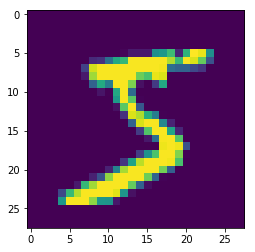

In [7]:
plt.imshow(X[0][0])

# Outils Communs

In [131]:
def run(episodes, model, loss, optim):
    ### Utilisation
    train_loss = []
    val_loss = []

    train_score = []
    val_score = []


    for i in tqdm(range(episodes)):
        costs_train = []
        scores_train = []

        for i,(data,target) in enumerate(train_loader):
            x = data.view(data.shape[0],-1)
            out = model.decode(model.encode(x))
            cost = loss(x, out)
            optim.zero_grad()
            cost.backward()
            optim.step()
            costs_train.append(cost)
            scores_train.append(model.score(x, out))
        train_loss.append(torch.tensor(costs_train).mean())
        train_score.append(torch.tensor(scores_train).mean())
    
         ####### Test #######
        costs_val = []
        scores_val = []
    
        for i,(data,target) in enumerate(test_loader):   
            x_test = data.view(data.shape[0],-1)
            out_test = model.decode(model.encode(x_test))
            cost_test = loss(x_test, out_test)
            costs_val.append(cost_test)
            scores_val.append(model.score(x_test, out_test))
        val_score.append(torch.tensor(scores_val).mean())
        val_loss.append(torch.tensor(costs_val).mean())
    return train_loss, train_score, val_score, val_loss    

In [128]:
def show_results(train_loss, train_score, val_score, val_loss):
    plt.figure(figsize=(10,7))
    plt.plot(train_score, c="red", label="train")
    plt.plot(val_score, c="b", label="val")
    plt.title('Score')
    plt.legend(loc="best")
    plt.show()
    
    plt.figure(figsize=(10,7))
    plt.plot(train_loss, c="red", label="train")
    plt.plot(val_loss, c="b", label="val")
    plt.title('Loss')
    plt.legend(loc="best")
    plt.show()

# Auto-Encodeur MLP

In [129]:
class AEL(nn.Module):
    
    def __init__(self, input_size, output_size, layers = []):
        super(AEL, self).__init__()
        self.layers = nn.ModuleList()
        for layer in layers:
            self.layers.append(nn.Linear(input_size, layer, bias = False))
            self.layers.append(nn.ReLU())
            input_size = layer
        self.linear = nn.Linear(input_size, output_size)
    
    def encode(self, X):
        out = X
        for i, layer in enumerate(self.layers):
            out = layer(out)
        return self.linear(out)
    
    def decode(self, X):
        out = torch.mm(self.linear.weight.t(),X.t())
        for i, layer in enumerate(self.layers[::-1]):
            if i % 2 == 1:
                out = torch.mm(layer.weight.t(),out)
            else:
                out = layer(out)
        return out.t()
        
    
    def score(self,y, ypred):
        """score = 0
        if len(y) != len(ypred):
            print('ERREUR')
        for i in range(0,len(y)):
            if y[i] == ypred[i].argmax():
                score += 1
        return(score/len(y))"""
        return 1 - (torch.abs((y - ypred))>0.1).float().sum()/(len(y))
        
        













  0%|                                                   | 0/20 [00:00<?, ?it/s]











  5%|██▏                                        | 1/20 [00:23<07:22, 23.30s/it]











 10%|████▎                                      | 2/20 [00:46<06:59, 23.33s/it]











 15%|██████▍                                    | 3/20 [01:09<06:31, 23.02s/it]











 20%|████████▌                                  | 4/20 [01:31<06:05, 22.84s/it]











 25%|██████████▊                                | 5/20 [01:54<05:42, 22.82s/it]











 30%|████████████▉                              | 6/20 [02:16<05:19, 22.80s/it]











 35%|███████████████                            | 7/20 [02:38<04:53, 22.54s/it]











 40%|█████████████████▏                         | 8/20 [03:00<04:28, 22.41s/it]











 45%|███████████████████▎                       | 9/20 [03:23<04:07, 22.47s/it]











 50%|█████████████████████                     | 10/20 [03:45<03:42, 22.26s/it

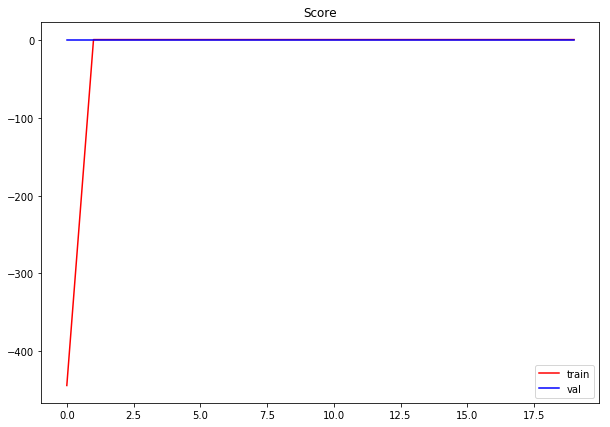

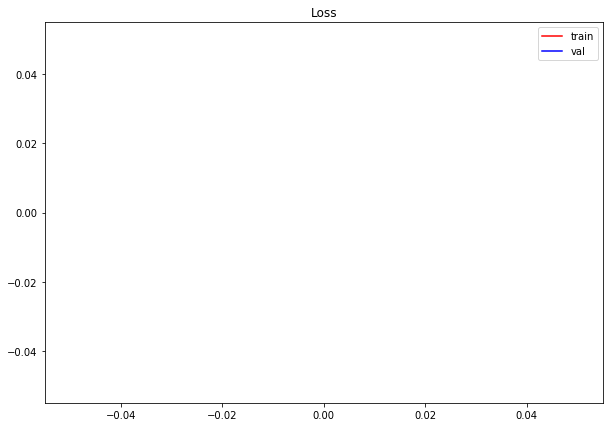

In [157]:
episodes = 20
model = AEL(X.shape[1], 2,[30])
loss = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)

train_loss, train_score, val_score, val_loss = run(episodes, model, loss, optim)
show_results(train_loss, train_score, val_score, val_loss)

In [158]:
out = model.encode(X)

In [159]:
init = model.decode(out)

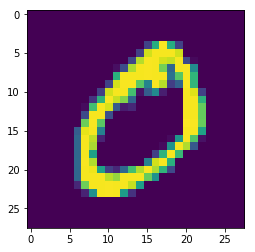

In [160]:
plt.imshow(X.view(600,28,28)[1])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:412: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:417: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


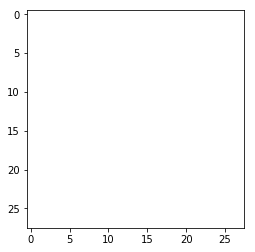

In [162]:
plt.imshow(init.view(600,28,28).detach().numpy()[1])

In [147]:
X = X.view(600, -1)
X_aff = X.view(600, 28, 28)

(600, 2)


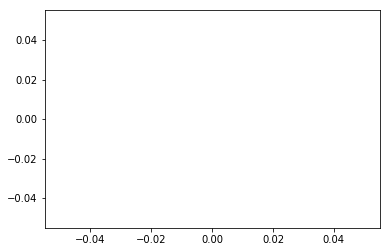

In [171]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

fig, ax = plt.subplots()
ax.scatter(out[:20][0], out[:20][1]) 
init = X.view(600, 28, 28)
out = model.encode(X).detach().numpy()
print(out.shape) #600,2
for i in range(20):
    ab = AnnotationBbox(OffsetImage(init[i].squeeze(), zoom=1), (out[i][0], out[i][1]), xycoords='data', frameon=False)
    ax.add_artist(ab)

RuntimeError: t() expects a 2D tensor, but self is 1D

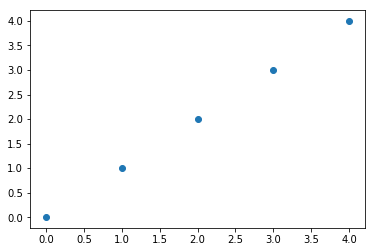

In [151]:
fig, ax = plt.subplots()
ax.scatter(range(5), range(5)) 
for i in range(5):
    ab = AnnotationBbox(OffsetImage(model.decode(model.encode(X[i])).view(28,28).squeeze(), zoom=1), (i, i), xycoords='data', frameon=False)
    ax.add_artist(ab)

# Auto-Encodeur Linéaire